In [2]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

Let's take a look at the dataset.

In [133]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y_train = train_df['failure']

train_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


The product code is of interest because we have no overlap between training and testing product codes. This is also true for each of the attribute features. We must take this into account when engineering features.

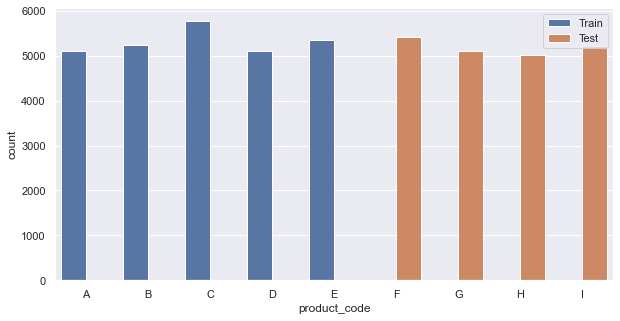

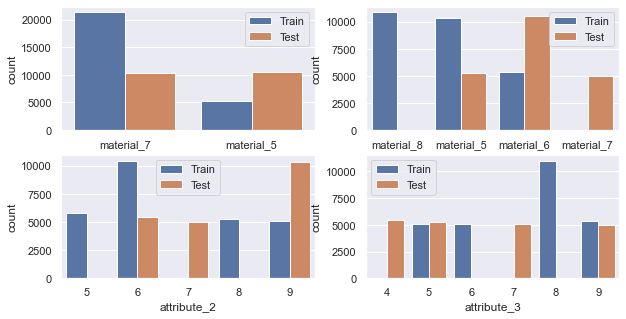

In [216]:
#hide_input
combo = pd.concat((train_df,test_df))
type_ = ['Train'] *len(train_df) + ['Test'] * len(test_df)

sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(data=combo, x='product_code',hue=type_)
plt.show()

fig, axs = plt.subplots(ncols=2,nrows=2)
sns.countplot(data=combo, x='attribute_0',hue=type_, ax=axs[0,0])
sns.countplot(data=combo, x='attribute_1',hue=type_, ax=axs[0,1])
sns.countplot(data=combo, x='attribute_2',hue=type_, ax=axs[1,0])
sns.countplot(data=combo, x='attribute_3',hue=type_, ax=axs[1,1])
plt.show()

We have a mix of categorical and numerical features (loading and all measurements being the numerical). Let's now take a look at the missing values within the training set. 

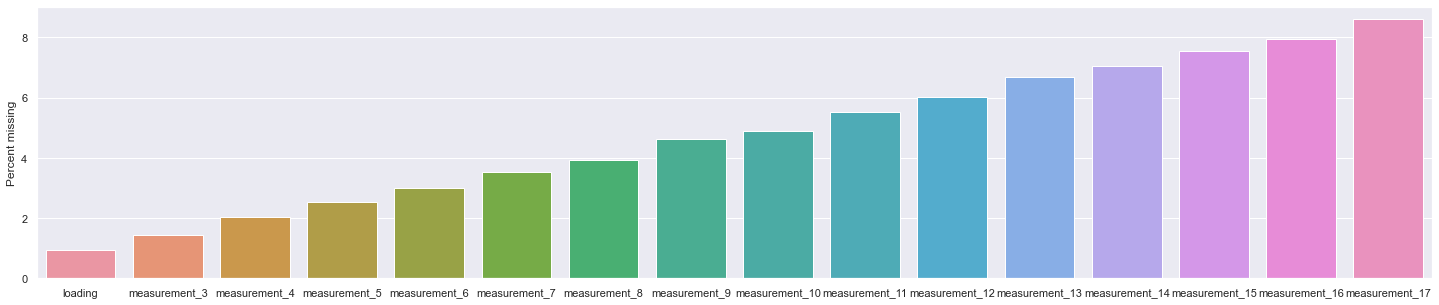

In [102]:
keys = []
vals = []
for col in train_df:
    if train_df[col].isna().sum() > 0:
        val = train_df[col].isna().sum()/len(train_df)*100
        keys.append(col)
        vals.append(val)

sns.set(rc={'figure.figsize':(25,5)})
ax = sns.barplot(x=keys,y=vals)
ax.set_ylabel('Percent missing')
plt.show()

None of the categorical features are missing which is great. We do see a trend in more missing values for the ordinally higher measurements. Before digging deeper, we can do a z-test to determine the p-value for features with missing values having a significantly different failure rate than the mean failure rate. Credit to @AmbrosM for the idea

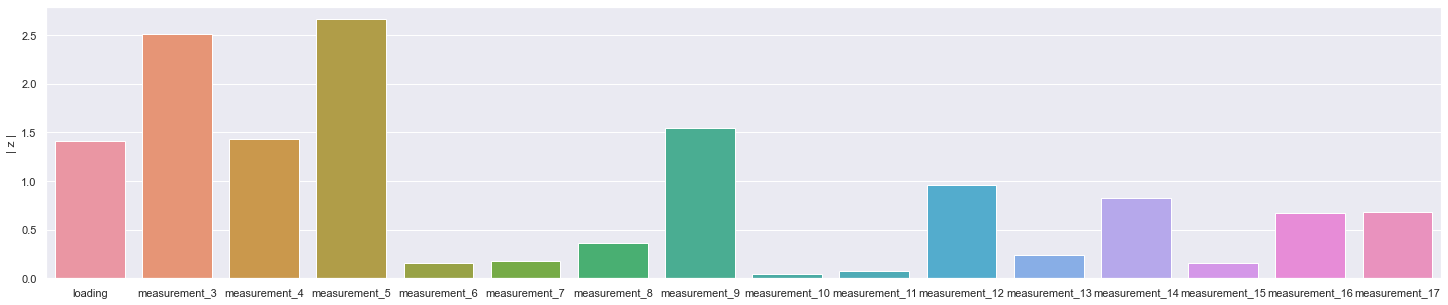

In [108]:
keys = []
vals = []
xbar = np.average(y_train) # Average failure rate for all samples

for col in train_df:
    if train_df[col].isna().sum() > 0:
        mask = (train_df[col].isna()) & (y_train.values ==1) 
        fail = mask.sum()
        total = train_df[col].isna().sum()
        keys.append(col)
        vals.append(np.abs((fail - xbar*total) / np.sqrt(total*xbar*(1-xbar))))
ax = sns.barplot(keys,vals)
ax.set_ylabel('| z |')
plt.show()

In the plot above, measurement_3 and measurement_5 are the only features with z scores greater than 1.96 meaning at an alpha of 0.05, our observations are significant. We can use this information to create new features that take on a 0 or 1 value depending on whether the corresponding measurement is missing.

Let's also look at how the loading feature is distributed across failure.

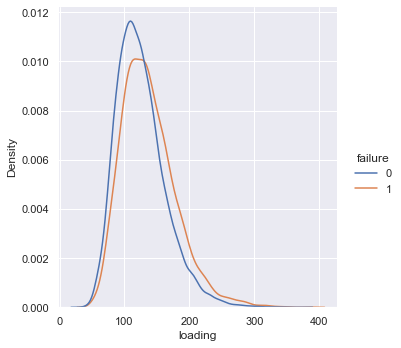

In [148]:
#collapse
sns.set(rc={'figure.figsize':(10,50)})
sns.displot(train_df,x='loading',hue='failure', kind='kde', common_norm=False)
plt.show()

It becomes obvious that items who failed have on average a higher loading value than those that do not fail. We can encode this as a feature by taking on a boolean value if the loading is closer to the mean loading value for failing items or passing items.

In [219]:
passingAvg = train_df[y_train==0]['loading'].mean()
failingAvg = train_df[y_train==1]['loading'].mean()
print('Loading Mean for Passing: ' + str(np.round(passingAvg,2)))
print('Loading Mean for Failure: ' + str(np.round(failingAvg,2)))

Loading Mean for Passing: 125.21
Loading Mean for Failure: 137.51


Before beginning training, we should first ask ourselves what is the best way to evaluate our model. Is accuracy enough or can we use a better metric such as AUROC/AUPRC? If so, which to choose? Let's first evaulate the distribution of classes

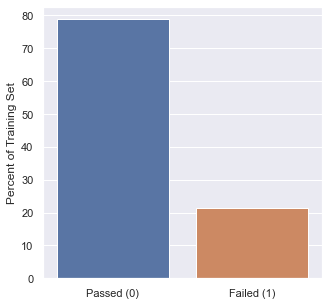

In [117]:
percentFailTrain = sum(y_train)/len(y_train)*100
keys = ['Failed (1)','Passed (0)']
vals = [percentFailTrain,100-percentFailTrain]

sns.set(rc={'figure.figsize':(5,5)})
ax = sns.barplot(keys[::-1],vals[::-1])
ax.set_ylabel('Percent of Training Set')
plt.show()

We can see that there is approximately a 4:1 distribution of classes in the dataset, which is unbalanced enough to warrant the use of the PR curve, since the AUROC is biased when used for unbalanced datasets. Let's first process our raw data by imputing missing values, adding new features, and encoding categorical variables.

In [116]:
def train(train,val,y_train,y_val,param,num_round,doVal=True,sklearn=False):
    dtrain = xgb.DMatrix(train, y_train, enable_categorical=True)      

    if sklearn:
        bst = make_pipeline(StandardScaler(), LogisticRegression())
        bst = bst.fit(train,y_train)
    else:
        bst = xgb.train(param, dtrain, num_round)
    
    if doVal:
        if sklearn:
            val_preds = bst.predict(val)
        else:
            dval = xgb.DMatrix(val,y_val, enable_categorical=True)
            val_preds = bst.predict(dval)
        val_preds = val_preds >= 0.5
        accuracy = np.round(sum(val_preds==y_val)/len(val_preds),4)*100
        return bst, accuracy
    else:
        return bst

In [238]:
def predict(test,bst,to_file=False,ids=None,sklearn=True,threshold=0.5):
    if sklearn:
        preds = bst.predict(test)
    else:
        dtest = xgb.DMatrix(test, enable_categorical=True)
        preds = bst.predict(dtest)

    
    if to_file:
        p = preds >= threshold
        sub = pd.DataFrame({'id':ids, 'failure':p.astype(int)})
        sub.to_csv('submission.csv', index=False)  
    return preds

In [278]:
train_df = pd.read_csv('train.csv') # 26570 rows
test_df = pd.read_csv('test.csv') # 20775 rows
y = train_df.pop('failure')

#Combine train and test for preprocess
combined = pd.concat((train_df,test_df),axis=0)

# Add features for missing values
combined['m3'] = combined['measurement_3'].isna()
combined['m5'] = combined['measurement_5'].isna()

# Imput missing values with mean of train_df
features = [f for f in train_df.columns if f == 'loading' or f.startswith('measurement')]
for col in features:
    avg = train_df[col].mean() # get the mean from just the training data to avoid leakage
    combined[col] = combined[col].fillna(avg)

# Engineer features
combined['area'] = combined['attribute_2']*combined['attribute_3']
combined.pop('attribute_2')
combined.pop('attribute_3')
materialCombinations = np.zeros((len(combined),4)) # create bool columns for material present in each item
for attr in ['attribute_0','attribute_1']:
    for i in range(len(combined)):
        mat = combined[attr].iloc[i]
        if mat == 'material_5':
            materialCombinations[i,0] = 1
        elif mat =='material_6':
            materialCombinations[i,1] = 1
        elif mat == 'material_7':
            materialCombinations[i,2] = 1
        elif mat == 'material_8':
            materialCombinations[i,3] = 1
        else:
            pass
combined.pop('attribute_0')
combined.pop('attribute_1')
combined['mat5'] = materialCombinations[:,0].tolist()
combined['mat6'] = materialCombinations[:,1].tolist()
combined['mat7'] = materialCombinations[:,2].tolist()
combined['mat8'] = materialCombinations[:,3].tolist()

# Add column for if loading is less than respective to failure
avg = np.mean([passingAvg,failingAvg])
combined['pomAvg'] = combined['loading'] >= avg

# Split back
train_df = combined.iloc[:26570]
test_df = combined.iloc[26570:]

# Bin numerical cols
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
features = [f for f in train_df if f.startswith('measurement') and f not in ['measurement_17']]
est.fit(train_df[features])
train_df[features] = est.transform(train_df[features])
test_df[features] = est.transform(test_df[features])


# Remove id column since it does not need to go in the model
train_df.pop('id')
ids = test_df.pop('id')

# Remove unimportant columns
features = [f for f in train_df if f.startswith('attribute') or f in ['measurement_' + str(i) for i in range(17)]]
for f in features:
    train_df.pop(f)
    test_df.pop(f)

Now that we have processed our data, we can train a model, tracking statistics to tell us our model's ability. Importantly, we must set up a validation split of our training data to accurately gauge our model's performance. Another note is that our model must account for the imbalance in the dataset or it will be biased towards predicting the dominant value in the dataset. We can sample our positive classes more than our negative classes to balance this out. Another alternative is to adjust the threshold that we make the positive/negative discrimination at.

In [367]:
avg_acc = []
avg_auroc = []
avg_auprc = []
avg_f1 = []

param = {'max_depth':6, 'eta':0.15, 'objective':'binary:logistic','eval_metric':'aucpr','gamma':10,'scale_pos_weight':0.8/0.2}
num_round = 5

features = [f for f in train_df.columns if f != 'product_code']

kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_df, y, train_df.product_code)):
    X_train, y_train = train_df.iloc[idx_tr], y[idx_tr]
    X_val, y_val = train_df.iloc[idx_va], y[idx_va]
    bst, val_acc = train(X_train[features],X_val[features],y_train,y_val,param,num_round,sklearn=False)

    y_pred = predict(X_val[features],bst,to_file=False,sklearn=False)
    auprc = average_precision_score(y_val, y_pred)
    auroc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val,y_pred>=0.3412498)

    avg_acc.append(val_acc)
    avg_auroc.append(auroc)
    avg_auprc.append(auprc)
    avg_f1.append(f1)

    print('Fold ' + str(fold) + ': Accuracy is ' + str(val_acc) + '. AUPRC is ' + str(auprc) + '. AUROC is ' + str(auroc) + '. F1 is ' + str(f1))
print('\n')
print('Average Accuracy: ' + str(np.round(np.mean(avg_acc),3)) + '. Average AUROC: ' + str(np.round(np.mean(avg_auroc),3)) + '. Average AUPRC: ' + str(np.round(np.mean(avg_auprc),3)) + '. Average F1: ' + str(np.round(np.mean(avg_f1),3)))  

Fold 0: Accuracy is 55.32. AUPRC is 0.26701863220704725. AUROC is 0.5810596223556782. F1 is 0.3497047385856258
Fold 1: Accuracy is 53.080000000000005. AUPRC is 0.2541565756241752. AUROC is 0.5724197961555418. F1 is 0.34347826086956523
Fold 2: Accuracy is 48.59. AUPRC is 0.2447654900636433. AUROC is 0.575729072507821. F1 is 0.33428662217985383
Fold 3: Accuracy is 50.67. AUPRC is 0.2721317459687122. AUROC is 0.5880387814748201. F1 is 0.357500403681576
Fold 4: Accuracy is 52.449999999999996. AUPRC is 0.2872029455067862. AUROC is 0.5852282118977086. F1 is 0.3705007198848184


Average Accuracy: 52.022. Average AUROC: 0.58. Average AUPRC: 0.265. Average F1: 0.351


I tuned the hyperparameters by maximizing the AUPRC and F1 score averages for each fold. Now, we can peek under the hood of our XGBoost model and see what features were most important.

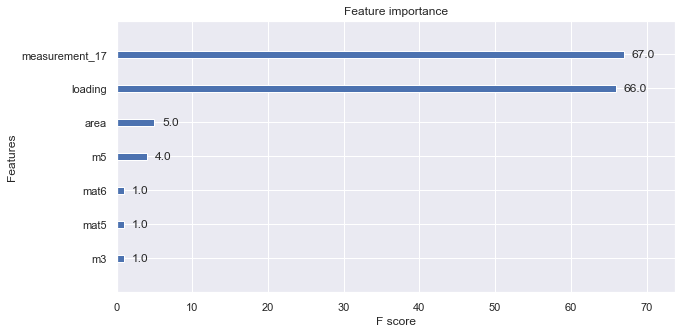

In [368]:
plot_importance(bst)
plt.show()

Two features seem to dominate the model, which is not unreasonable. Our missing values features are less important than I'd hoped, and our encoded features of what materials we are using are useless it turns out. None the less, we've added useful features to help our model predict better.

Once we have a model that we are happy with, let's retrain on the entirety of our training dataset and make predictions on the test set. Here, we disregard the validation datasets.

In [364]:
bst = train(train_df[features],[],y,[],param,num_round,doVal=False)

In [365]:
features = [f for f in test_df.columns if f != 'product_code']
preds = predict(test_df[features],bst,to_file=True,ids=ids,sklearn=False,threshold=0.3412498)

We now save our predictions to a CSV for evaluation.

In [366]:
sub = pd.DataFrame({'id':ids, 'failure':preds})
sub.to_csv('submission.csv', index=False) 